In [1]:
!gdown -q 1p2g68kxvXnez9yc2nhD6XJ0aGTx2tyRX

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Sparse Optical Flow

In [3]:
def sparse_optical_flow_tracking(video_path, bbox, output_path):
    cap = cv2.VideoCapture(video_path)

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    ret, first_frame = cap.read()
    old_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
    x, y, w, h = bbox
    roi_mask = np.zeros_like(old_gray)
    roi_mask[y:y+h, x:x+w] = 255
    feature_params = dict(
        maxCorners=50,
        qualityLevel=0.3,
        minDistance=7,
        blockSize=7
    )

    # Detect good features to track in ROI
    p0 = cv2.goodFeaturesToTrack(old_gray, mask=roi_mask, **feature_params)

    if p0 is None:
        print("Error: No features detected in ROI")
        return

    print(f"Tracking {len(p0)} feature points")

    # Parameters for Lucas-Kanade optical flow
    lk_params = dict(
        winSize=(15, 15),
        maxLevel=2,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
    )

    # Create video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Colors for visualization
    color = np.random.randint(0, 255, (100, 3))


    # Create a mask image for drawing purposes
    mask = np.zeros_like(first_frame)

    frame_idx = 0
    last_frame = None
    # Process video
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_idx += 1
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

        # Select good points
        if p1 is not None:
            good_new = p1[st == 1]
            good_old = p0[st == 1]

            # draw the tracks
            for i, (new, old) in enumerate(zip(good_new, good_old)):
                a, b = new.ravel()
                c, d = old.ravel()
                a, b, c, d = int(a), int(b), int(c), int(d)

                mask = cv2.line(mask, (a, b), (c, d), color[i].tolist(), 2)
                frame = cv2.circle(frame, (a, b), 5, color[i].tolist(), -1)

        output_frame = cv2.add(frame, mask)
        last_frame = output_frame.copy()

        out.write(output_frame)

        # Now update the previous frame and previous points
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)

        if frame_idx % 30 == 0:
            print(f"Processed {frame_idx}/{frame_count} frames")


    if last_frame is not None:
        cv2.imwrite('sparse_last_frame.png', last_frame)
    cap.release()
    out.release()

    return last_frame

# Dense Optical Flow

In [4]:
def dense_optical_flow_tracking(video_path, output_path):
    cap = cv2.VideoCapture(video_path)

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    ret, first_frame = cap.read()
    if not ret:
        print("Error: Cannot read video")
        return

    old_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    hsv = np.zeros_like(first_frame)
    hsv[..., 1] = 255

    frame_idx = 0
    last_frame = None

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_idx += 1
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        flow = cv2.calcOpticalFlowFarneback(old_gray, frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        hsv[..., 0] = ang * 180 / np.pi / 2
        hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
        flow_rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

        # Blend original frame with flow visualization
        output_frame = cv2.addWeighted(frame, 0.3, flow_rgb, 0.7, 0)
        last_frame = flow_rgb.copy()

        out.write(output_frame)

        # Update for next iteration
        old_gray = frame_gray.copy()

        if frame_idx % 30 == 0:
            print(f"Processed {frame_idx}/{frame_count} frames")

    if last_frame is not None:
        cv2.imwrite('dense_last_frame.png', last_frame)
    cap.release()
    out.release()

    return last_frame

In [5]:
INITIAL_BBOX = [420, 320, 335, 230]

VIDEO_PATH = "Car Driving Over Bridge At Night Royalty Free Stock Aerial Drone Footage..mp4"

# Run Sparse Optical Flow Tracking
sparse_last_frame = sparse_optical_flow_tracking(
    VIDEO_PATH,
    INITIAL_BBOX,
    'sparse_tracking.avi'
)

print("+++++++++++++++++++")
# Run Dense Optical Flow Tracking
dense_last_frame = dense_optical_flow_tracking(
    VIDEO_PATH,
    'dense_tracking.avi'
)

Tracking 18 feature points
Processed 30/409 frames
Processed 60/409 frames
Processed 90/409 frames
Processed 120/409 frames
Processed 150/409 frames
Processed 180/409 frames
Processed 210/409 frames
Processed 240/409 frames
Processed 270/409 frames
Processed 300/409 frames
Processed 330/409 frames
Processed 360/409 frames
Processed 390/409 frames
+++++++++++++++++++
Processed 30/409 frames
Processed 60/409 frames
Processed 90/409 frames
Processed 120/409 frames
Processed 150/409 frames
Processed 180/409 frames
Processed 210/409 frames
Processed 240/409 frames
Processed 270/409 frames
Processed 300/409 frames
Processed 330/409 frames
Processed 360/409 frames
Processed 390/409 frames


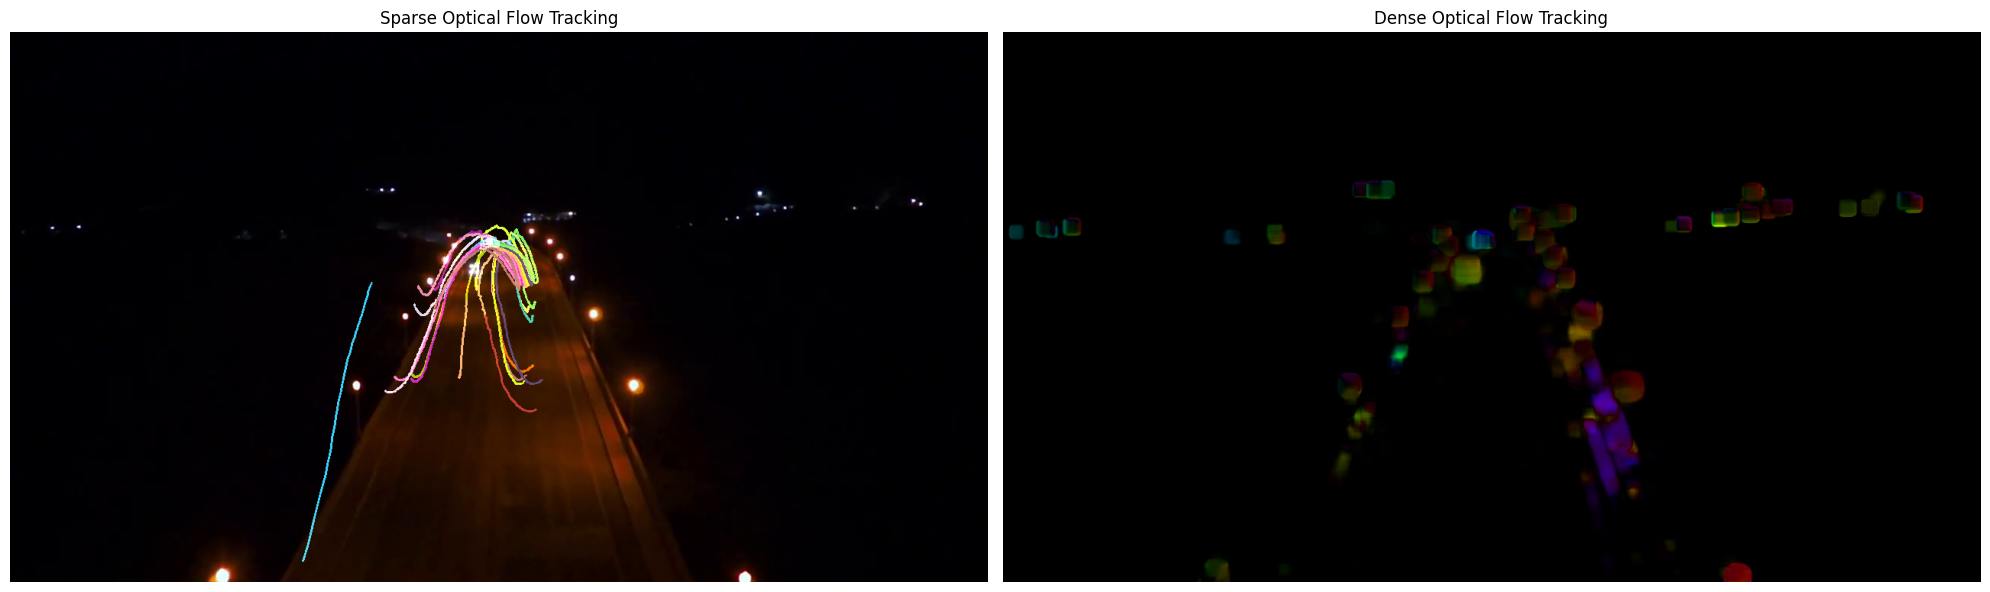

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(sparse_last_frame, cv2.COLOR_BGR2RGB))
axs[0].set_title('Sparse Optical Flow Tracking')
axs[0].axis('off')
axs[1].imshow(cv2.cvtColor(dense_last_frame, cv2.COLOR_BGR2RGB))
axs[1].set_title('Dense Optical Flow Tracking')
axs[1].axis('off')
plt.tight_layout()
plt.show()